<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/dsviz/W&B_Dataset_and_Predictions_Viz_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{dviz-segmentation} -->

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{dviz-segmentation} -->

_W&B Datasets & Predictions is currently in the early-access phase. You can use it in our production service at [wandb.ai](https://wandb.ai), with [some limitations](https://docs.wandb.com/datasets-and-predictions#current-limitations). APIs are subject to change. We'd love to hear questions, comments, and ideas! Drop us a line at feedback@wandb.com._

# W&B Dataset Visualization Demo

This notebook demonstrates W&B's dataset visualization features. In particular we show how [W&B Artifacts](https://docs.wandb.com/artifacts) help visualize datasets and predictions, focusing on image data. We track model and data lineage and perform interactive  analysis on the resulting datasets. The overall flow will be:

1. Create a dataset
2. Split the dataset into "train" and "test"
3. Train a model on the "train" dataset
4. Load the trained model and log predictions on both datasets
5. Analyze the results in W&B's UI

You can see live interactive examples logged to W&B in this public project: [Dsviz Demo](https://wandb.ai/stacey/dsviz-demo).

### Explore your training data
<img src="https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/overview_data_table.png" width=600 height=300>

### Visualize your model predictions
<img src="https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/overview_val_predictions.png" width=500 height=300>






# Step 0: Setup

## Install requirements & utils

For brevity, we put utility functions for working with the dataset in `util.py`.

In [1]:
# Download a util file of helper methods for this notebook
!curl https://raw.githubusercontent.com/staceysv/dsviz-demo/master/util.py --output util.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7238  100  7238    0     0  18997      0 --:--:-- --:--:-- --:--:-- 18947


In [8]:
from fastai.vision.all import *
import wandb
print(wandb.__version__)

0.13.2


## Login to wandb


In [3]:
WANDB_PROJECT = "dsviz-demo"

Set SIZE to "TINY", "MEDIUM" or (read the warning) "LARGE" to select one of these datasets
- TINY dataset: 50 images
- MEDIUM dataset: 200 images
- LARGE dataset: 400 images 
> warning: you may run out of RAM in Colab & need to restart the notebook between steps at this size

In [4]:
SIZE = "TINY"
PREFIX = "bdd"

if SIZE == "TINY":
    NUM_EXAMPLES = 50
    SPLITS = {"train" : 40, "test" : 10}
elif SIZE == "MEDIUM":
    NUM_EXAMPLES = 200
    SPLITS = {"train" : 160, "test" : 40}
elif SIZE == "LARGE": 
    NUM_EXAMPLES = 400
    SPLITS = {"train" : 320, "test" : 80}

# set globals
IMAGE_ROOT = "segment_demo/images/train"
LABEL_ROOT = "segment_demo/labels/train"

# set global Artifact names (allowing steps to be rerun independently)
RAW_DATA_AT = "_".join([PREFIX, "raw_data", str(NUM_EXAMPLES)])
TRAIN_DATA_AT = "_".join([PREFIX, "train_data", str(NUM_EXAMPLES)])
TEST_DATA_AT = "_".join([PREFIX, "test_data", str(NUM_EXAMPLES)])

In [45]:
RAW_DATA_AT, TRAIN_DATA_AT, TEST_DATA_AT

('bdd_raw_data_50', 'bdd_train_data_50', 'bdd_test_data_50')

## Download the data

Before we get started, we will download an example dataset to our local machine. This is a big dataset (958MB) so please be patient if you are on a slow connection. we will use fastai's `untar_data` function to download and decompress our dataset.

In [12]:
path = untar_data("https://storage.googleapis.com/wandb_datasets/BDD100K_seg_demo.zip")

we have 2 folders, one with RGB images and one with labels:

In [14]:
path.ls()

(#2) [Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/images'),Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/labels')]

In [16]:
fnames = get_image_files(path/"images")

In [18]:
labels = get_image_files(path/"labels")

In [19]:
fnames[0], labels[0]

(Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/images/train/baa79505-43ff4345.jpg'),
 Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/labels/train/1a92b5b9-87a40001_train_id.png'))

In [20]:
fname = fnames[0]

Let's create a helper function in the `Path` class

In [26]:
@patch
def with_custom_suffix(self: Path, suffix):
    return self.parent/(self.name.split(".")[0] + suffix)

In [27]:
fname.with_custom_suffix("_train_id.png")

Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/images/train/baa79505-43ff4345_train_id.png')

## Show some example training images

In [41]:
def label_func(fname):
    "Get the corresponding label"
    dataset_path = fname.parent.parent.parent
    train_valid = fname.parent.name
    return ((dataset_path/"labels")/train_valid)/(fname.with_custom_suffix("_train_id.png")).name

In [42]:
label_func(fname)

Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/labels/train/66fab43d-767bd2c0_train_id.png')

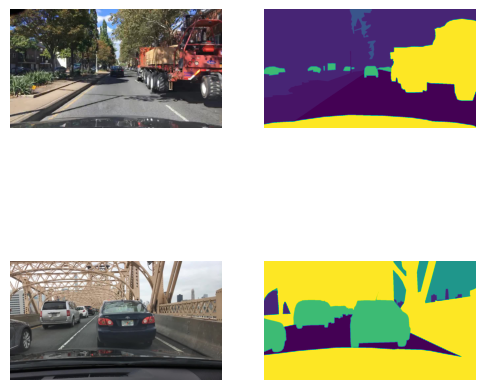

In [43]:
axes = subplots(2, 2)[1]
for fname, ax in zip(fnames, axes):
    label = label_func(fname)
    pil_img, pil_lbl = load_image(fname), load_image(label)
    show_image(pil_img, ax=ax[0])
    show_image(pil_lbl, ax=ax[1])

# Step 1: Build the dataset

First, let's build a dataset for use in the rest of this project using a `wandb.Run`. A `Run` is an isolated process which can optionally depend on upstream artifacts as well as optionally produce artifacts for later consumption. In this step, we will create a `wandb.Table` during our run and output it in an artifact. This table will contain all of our raw data for later use. W&B also offers rich tools to analyze and visualize such Tables in an interactive UI.

[See a live example of the raw dataset in W&B](https://wandb.ai/stacey/dsviz-demo/artifacts/raw_data/bdd_raw_data_500/afcb923f719b14370215/files/raw_examples.table.json)

In [ ]:
from PIL import Image

# Initialize the run
run = wandb.init(project=WANDB_PROJECT,
                 job_type="upload",
                 config={
                     "num_examples" : NUM_EXAMPLES,
                     "num_train" : SPLITS["train"],
                     "num_test" : SPLITS["test"]
                 })

# Setup a WandB Classes object. This will give additional metadata for visuals
class_set = wandb.Classes([{'name': name, 'id': id} 
                           for name, id in zip(util.BDD_CLASSES, util.BDD_IDS)])

# Create an Artifact (versioned folder)
artifact = wandb.Artifact(name=RAW_DATA_AT, type="raw_data")

# Setup a WandB Table object to hold our dataset
columns=["id", "raw", "annotated", "color_mask", "raw_label"]
# add a column for the pixel fraction of each class label
columns.extend(["%_" + c for c in util.BDD_CLASSES])
table = wandb.Table(
    columns=columns
)

# temporary directory to hold intermediate visualizations
TMPDIR = "tmp_labels"
if not os.path.isdir(TMPDIR):
    os.mkdir(TMPDIR)

# Fill up the table
all_images = [f for f in os.listdir(IMAGE_ROOT)]
for ndx in range(wandb.config.num_examples):
    img = all_images[ndx]
    img_file = os.path.join(IMAGE_ROOT, img)
    train_id = img.split(".")[0]
    label_file = os.path.join(LABEL_ROOT, train_id + "_train_id.png")

    # First, we will build a wandb.Image to act as our raw example object
    #    classes: the classes which map to masks and/or box metadata
    #    masks: the mask metadata. In this case, we use a 2d array w
    #           here each cell corresponds to the label (this comes directly from the dataset)
    raw_img = wandb.Image(img_file)
    annotated = wandb.Image(img_file, classes=class_set,
                        masks={"ground_truth" : {"mask_data": np.array(Image.open(label_file))}})

    # Next, we create an additional image which may be helpful during analysis
    # and compute the fraction of each image covered by each of the classes
    # (so we can find examples with more pixels of cars vs pedestrians vs other
    # classes of interest). This additional metadata is optional
    class_fractions = util.count_pixels(label_file)
    raw_label = wandb.Image(label_file)

    # use .add_file for the files we need to reference by path
    # (in this case the training image and the label)
    artifact.add_file(img_file, os.path.join("images", img))
    artifact.add_file(label_file, os.path.join("labels", train_id + "_train_id.png"))

    # Finally, we add a row of our newly constructed data.
    row = [train_id, raw_img, annotated, color_mask, raw_label]
    row.extend(class_fractions)
    table.add_data(*row)
    
# .add the table to the artifact
artifact.add(table, "raw_examples")
    
# Finally, log the artifact
print("Saving data to WandB...")
run.log_artifact(artifact)
run.finish()
print("... Run Complete")

# clear out the temporary files 
shutil.rmtree(TMPDIR)

### Review the dataset in the Dashboard

Great, now if you click on the URL above, you should land on a run page. Since we did not log any metrics, there are no charts. Click the database icon (it looks like a stack of hockey pucks) on the left panel to see this run's artifacts. You should see something similar to the following:

![Raw Data](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/first_raw_artifact.png)

Click on the "`raw_data`" row to see an Oveview page like this:

![Raw Data](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/raw_examples_select_table.png)

Clicking on the "`raw_examples" entry under Tables will launch an interactive data explorer to review the table we just built. Here I've advanced to a page where you can see some humans.

![Raw Data](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/raw_examples_human_page.png)

You can also access this table as a json file under the "Files" tab, which lists all the files stored in this Artifact.
![Files list](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/raw_files_first_page.png)

# Step 2: Splitting the data into train and test

Next, we will split the data into a train and a test dataset. Similar to before, we will launch a `Run` to perform this operation. Remember, this new execution could happen on a different machine as we will dynamically load the needed resources. In particular, we will load in the raw dataset from the last run and split it into 2 new datasets.

See live examples of the [train data](https://wandb.ai/stacey/dsviz-segment/artifacts/train_data/bdd_train_data_200/4bb038903e618f8e0e49) and [test data](https://wandb.ai/stacey/dsviz-segment/artifacts/test_data/bdd_test_data_200/1d6aae785ea663167c82) artifacts in W&B.

In [ ]:
# Initialize a run (you can use the job_type to better organize runs)
run = wandb.init(project=WANDB_PROJECT, job_type="data_split")

# Get the latest version of the artifact. 
# Notice the name alias follows this convention: "<ARTIFACT_NAME>:<VERSION>"
# When version is set to "latest", then the latest version will always be used.
# However, you can pin to a version by using an alias such as "raw_data:v0"
data_at = run.use_artifact(RAW_DATA_AT + ":latest")
    
# Next, we .get the table by the same name that we saved it in the last run.
data_table = data_at.get("raw_examples")
    
# Print a row
print("\nExample Data row\n", data_table.data[0])
    
# Show an example image
print("\nExample Image\n")
plt.imshow(data_table.data[0][1].image)
plt.show()
    
# Notice that a new directory was made: artifacts which is managed by wandb
print("\nArtifact Directory Contents: \n", os.listdir("artifacts"))

# Now we can build two separate artifacts for later use. We will first split the raw table into two parts,
# then create two different artifacts, each of which will hold our new tables. We create two artifacts so that
# in future runs, we can selectively decide which subsets of data to download.
train_table = wandb.Table(columns=data_table.columns, data=data_table.data[:SPLITS["train"]])
test_table = wandb.Table(columns=data_table.columns, data=data_table.data[SPLITS["train"]:])

train_artifact = wandb.Artifact(TRAIN_DATA_AT, "train_data")
test_artifact = wandb.Artifact(TEST_DATA_AT, "test_data")

# Save the tables to the artifacts with .add
train_artifact.add(train_table, "train_table")
# Note: technically our test data has ground truth labels in this example :)
# we could modify this table to remove the labels
test_artifact.add(test_table, "test_table")

# Log the artifacts out as outputs of the run
print("Saving data to WandB...")
run.log_artifact(train_artifact)
run.log_artifact(test_artifact)
run.finish()
print("... Run Complete")

### Review the splits in the Dashboard
Notice, in this step, the raw_data `wandb.Table` was reinstatiated and the data, images, etc... came along for the ride. This makes it easy for ML practitioners on a team to share data and assets easily. To manage this, you can see that we created an artifacts directory to save local data.

Now we have two new datasets. Feel free to browse them similar to our last step. However, this time, click "Graph View" rather than "Files" to see the lineage of the artifact.

Naming and typing in Artifacts are powerful and flexible. In this case, we include a short prefix ("bdd" for Berkeley Deep Drive 100K) and the count of items in each artifact name so that these artifacts are easier to identify and track when viewed at a glance, downloaded locally, or compared to the many other versions we may create in this project (with different total counts, data split strategies, etc).

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/split_train_test.png)

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/test_data_graph.png)

We will come back to this graph view later on!

# Step 3: Model Training

Now we will train a model to predict semantic segmentation masks. This is a simple UNet in Fastai, intended to train quickly. As you can imagine, the model performance can be improved dramatically.

See a [live example in W&B](https://wandb.ai/stacey/dsviz-demo/artifacts/val_epoch_preds/val_pred_55oxnv95/8ea156e10e0099fe58d8/files/val_epoch_results.table.json) of validation predictions logged during training, versioned per epoch.

In [ ]:
from pathlib import Path
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callback import Callback
import json
from wandb.fastai import WandbCallback
from functools import partialmethod

# where to download files for local training
LOCAL_TRAIN_DIR = "TRAIN_DIR"

# Setup a WandB Classes object. This will give additional metadata for visuals
class_set = wandb.Classes([{'name': name, 'id': id} 
                           for name, id in zip(util.BDD_CLASSES, util.BDD_IDS)])

# wrapper for logging masks to W&B
def wb_mask(bg_img, pred_mask=[], true_mask=[]):
  masks = {}
  if len(pred_mask) > 0:
    masks["prediction"] = {"mask_data" : pred_mask}
  if len(true_mask) > 0:
    masks["ground truth"] = {"mask_data" : true_mask}
  return wandb.Image(bg_img, classes=class_set, masks=masks)

SMOOTH = 1e-6
# IOU loss function
def iou(input, target):
    target = target.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    intersection = (input.argmax(dim=1) & target).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (input.argmax(dim=1) | target).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0
    return iou.mean()

# Custom callback for logging images to W&B
class LogImagesCallback(Callback):

  def __init__(self, learn):
    self.learn = learn

  # log semantic segmentation masks
  def on_epoch_end(self, epoch, n_epochs, **kwargs):
    # optionally limit all these to store fewer images
    # e.g. by adding [:num_log] to every line
    train_batch = self.learn.data.train_ds
    train_ids = [a.stem for a in self.learn.data.train_ds.items]
    valid_batch = self.learn.data.valid_ds
    val_ids = [a.stem for a in self.learn.data.valid_ds.items]

    train_masks = []
    valid_masks = []

    # save training and validation predictions
    # note: we're training for 1 epoch for brevity, but this approach
    # will create a new version of the artifact for each epoch
    train_res_at = wandb.Artifact("train_pred_" + wandb.run.id, "train_epoch_preds")
    val_res_at = wandb.Artifact("val_pred_" + wandb.run.id, "val_epoch_preds")
    # store all final results in a single artifact across experiments and
    # model variants to easily compare predictions
    final_model_res_at = wandb.Artifact("resnet_pred", "model_preds")


    main_columns = ["id", "prediction", "ground_truth"]
    # we'll track the IOU for each class
    main_columns.extend(["iou_" + s for s in util.BDD_CLASSES])
    # create tables
    train_table = wandb.Table(columns=main_columns)
    val_table = wandb.Table(columns=main_columns)
    model_res_table = wandb.Table(columns=main_columns)


    for batch_masks, batch, batch_ids, table, phase in zip([train_masks, valid_masks],
                                                    [train_batch, valid_batch], 
                                                    [train_ids, val_ids],
                                                    [train_table, val_table],
                                                    ["train", "val"]):
      for i, img in enumerate(batch):
        # log raw image as array
        orig_image = img[0]
        bg_image = image2np(orig_image.data*255).astype(np.uint8)

        # verify prediction from the model
        prediction = self.learn.predict(img[0])[0]
        prediction_mask = image2np(prediction.data).astype(np.uint8)

        # ground truth mask
        ground_truth = img[1]
        true_mask = image2np(ground_truth.data).astype(np.uint8)

        # score masks: what is the IOU for each class?
        per_class_scores = [util.iou_flat(prediction_mask, true_mask, i) for i in util.BDD_IDS]
        row = [str(batch_ids[i]), wb_mask(bg_image, pred_mask=prediction_mask), 
                                  wb_mask(bg_image, true_mask=true_mask)]
        row.extend(per_class_scores)
        table.add_data(*row)
        # only for last epoch
        if phase == "val" and epoch == n_epochs - 1:
          model_res_table.add_data(*row)

    train_res_at.add(train_table, "train_epoch_results")
    val_res_at.add(val_table, "val_epoch_results")
    # by reference
    final_model_res_at.add(model_res_table, "model_results")
    wandb.run.log_artifact(train_res_at)
    wandb.run.log_artifact(val_res_at)
    wandb.run.log_artifact(final_model_res_at)

def train_model():
  # default settings / hyperparameters
  default_config = {
    "framework" : "fastai",
    "img_size" : (360, 640),
    "batch_size" : 8, # keep small in Colab to be manageable
    "epochs" : 1, # for brevity, increase for better results :)
    "data_split" : 0.7,
    "pretrained" : True  # whether to use pretrained encoder
  }
  run = wandb.init(project=WANDB_PROJECT, job_type="train", \
             config=default_config)
  
  cfg = wandb.config
  # resnet34 may also be manageable in this Colab :)
  cfg.encoder = "resnet18"
  encoder = models.resnet18

  # best config for hyperparameters from past sweeps
  cfg.weight_decay = 0.08173
  cfg.bn_weight_decay = True   # whether weight decay is applied on batch norm layers
  cfg.one_cycle = True         # use the "1cycle" policy -> https://arxiv.org/abs/1803.09820
  cfg.learning_rate = 0.002

  # fetch the latest verstion of the training data
  train_artifact = run.use_artifact(TRAIN_DATA_AT + ":latest")
  # download it locally (required for this Fastai approach)
  train_dir = train_artifact.download(LOCAL_TRAIN_DIR)

  # map each image file to its label file
  get_label = lambda x: str(x.parents[0]).replace("images", "labels") + "/"  + str(x.stem) + "_train_id.png"

  # load data into train & validation sets
  src = (SegmentationItemList.from_folder("./" + LOCAL_TRAIN_DIR + "/images")
       .split_by_rand_pct(cfg.data_split)
       .label_from_func(get_label, classes=util.BDD_CLASSES))
  # resize, augment, load in batch & normalize (so we can use pre-trained networks)
  data = (src.transform(get_transforms(), size=cfg.img_size, tfm_y=True)
        .databunch(bs=cfg.batch_size)
        .normalize(imagenet_stats))

  # define UNet model
  learn = unet_learner(
    data,
    arch=encoder,
    pretrained=cfg.pretrained,
    metrics=iou,
    wd=cfg.weight_decay,
    bn_wd=cfg.bn_weight_decay,
    callback_fns=partial(WandbCallback, save_model=True, monitor='iou'))
  
  # train model!
  learn.fit_one_cycle(
        cfg.epochs,
        max_lr=slice(cfg.learning_rate),
        callbacks=[LogImagesCallback(learn)])
  
  # save the trained model as an artifact
  # note: make this name more descriptive as you experiment so it's easier to track
  model_name = cfg.encoder 
  saved_model = wandb.Artifact(model_name, type="model")
  # export trained model
  learn.export(file = Path(model_name + ".pkl"))
  local_model_file = LOCAL_TRAIN_DIR + "/images/" + model_name + ".pkl"
  saved_model.add_file(local_model_file, name=model_name)
  print("Saving data to WandB...")
  run.log_artifact(saved_model)
  run.finish()
  print("... Run Complete")

In [ ]:
train_model()

# Step 4: Model Evaluation

Now that we have a trained model, we want to score it on the test data which was held out in step 2. This code is very similar to the training step, with the execption of slightly different naming. The important difference is that we load the saved model from the artifact. Note that the test predictions will be pretty weak if you're training on the TINY dataset for only one epoch :)

See a [live example in W&B](https://wandb.ai/stacey/dsviz-seg/artifacts/test_preds/test_preds_2ghlr3bh/b13a107bb3cb1e2a249c/files/test_results.table.json) of such test predictions.

In [ ]:
run = wandb.init(project=WANDB_PROJECT, job_type="test")
LOCAL_MODEL_DIR = "MODEL"

# note: this model is hardcoded for convenience
model_artifact = run.use_artifact("resnet18:latest")
path = model_artifact.get_path("resnet18").download()

# a bit of path gymnastics for fastai
model_file = path.split("/")[-1]
model_load_path = "/".join(path.split("/")[:-1])
# load model via fastai
unet_model = load_learner(Path(model_load_path), model_file)

# create test result artifact
test_artifact = run.use_artifact(TEST_DATA_AT + ":latest")

# download test images so they are available locally
test_dir = test_artifact.download(LOCAL_MODEL_DIR)
test_images_path =  Path(test_dir + "/images/")
print("TEST: ", test_images_path)
# create test dataset in fastai
test_data = ImageList.from_folder(test_images_path)
unet_model.data.add_test(test_data, tfms=None, tfm_y=False)

test_batch = unet_model.data.test_ds
test_ids = unet_model.data.test_ds.items

test_res_at = wandb.Artifact("test_pred_" + wandb.run.id, "test_preds")
test_table = wandb.Table(columns=["id", "prediction"])

# store predictions across all resnet model variants as one artifact
model_test_at = wandb.Artifact("resnet_results", "model_test")
model_test_table = wandb.Table(columns=["id", "prediction"])

for i, img in enumerate(test_batch):
   # log raw image as array
   orig_image = img[0]
   bg_image = image2np(orig_image.data*255).astype(np.uint8)

   # our prediction
   prediction = unet_model.predict(orig_image)[0]
   prediction_mask = image2np(prediction.data).astype(np.uint8)
   test_id = str(test_ids[i]).split("/")[-1].split(".")[0]

   # create prediction mask and log to table
   row = [str(test_id), wb_mask(bg_image, pred_mask=prediction_mask)]
   test_table.add_data(*row)
   model_test_table.add_data(*row)

print("Saving data to WandB...")
test_res_at.add(test_table, "test_results")
run.log_artifact(test_res_at)
model_test_at.add(model_test_table, "model_test_results")
run.log_artifact(model_test_at)
print("... Run Complete")


# Step 5: Model Analysis

This is where it all comes together. In this step, we join the train and test scoring results with the original dataset and output corresponding artifacts. The new idea introduced here is a `wandb.JoinedTable` which allows you to join two `Table`s for further analysis in the UI.

[See a live example of all these tables](https://wandb.ai/stacey/dsviz-seg/artifacts/analysis/resnet_summary/b3054ed6229e43371365)

In [ ]:
with wandb.init(project=WANDB_PROJECT, job_type="analysis") as run:
    
    # Retrieve the original raw dataset
    dataset_artifact = run.use_artifact(RAW_DATA_AT + ":latest")
    data_table = dataset_artifact.get("raw_examples")
    
    # Retrieve the train and test score tables
    train_artifact = run.use_artifact("resnet_pred:latest")
    train_table = train_artifact.get("model_results")
    
    test_artifact = run.use_artifact("resnet_results:latest")
    test_table = test_artifact.get("model_test_results")
    
    # Join the tables on ID column and log them as outputs.
    train_results = wandb.JoinedTable(train_table, data_table, "id")
    test_results = wandb.JoinedTable(test_table, data_table, "id")
    
    artifact = wandb.Artifact("resnet_summary", "analysis")
    artifact.add(train_results, "train_results")
    artifact.add(test_results, "test_results")
    run.log_artifact(artifact)
    
    print("Saving data to WandB...")
print("... Run Complete")

### Review the model analysis in the Dashboard
Now, click on the above **Project** page (second link). This will look like the following:

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/project_landing.png)

Click on the database icon, as previously, to see the artifacts. This time, you are seeing the artifacts for the entire project, with counts of their versions:

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/many_artifact_types.png)

Go ahead and click the "`model`" artifact type, "Files", and "`model.pkl`". The viewer will provide different renderings based on the file type. For a pickled class, you get the following image. For deep networks saved as `.h5` files, you can see all the layers and their attributes.

![](https://raw.githubusercontent.com/wandb/dsviz-demo/master/notebook_images/model_view.png)

Next, head back to the artifact page, click Database type, expand `summary_results`, and select your most recent version. Click "Files" and select one of the join tables:

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/pred_detail.png)

Zooming out a bit, you can toggle the bounding boxes, masks, group, filter, and sort the data:

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/zoom_out_table.png)

![](https://raw.githubusercontent.com/wandb/dsviz-demo/master/notebook_images/grouped.png)

Finally, click graph view, and "explode". Now, you can visualize the entire process end-to-end:

![](https://raw.githubusercontent.com/wandb/dsviz-demo/master/notebook_images/summary_graph.png)